#Demo NeuroEvolution usando Tensorflow-Neuroevolution framework (TFNE) para generar una RNA que pueda aprender a estimar en base a ejemplos
Fuente TFNE: https://github.com/PaulPauls/Tensorflow-Neuroevolution

0) Preparar ambiente:

In [ ]:
#@title Instalar TFNE
!pip install tfne

###!git clone https://github.com/PaulPauls/Tensorflow-Neuroevolution
###%cd Tensorflow-Neuroevolution
###!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.1/338.1 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 9.1 MB/s eta 0:00:00


1) Cargar librerías:

In [ ]:
#@title Librerías a usar
from __future__ import annotations
from absl import app, flags, logging

import numpy as np
import tensorflow as tf
import pandas as pd

import os
import csv

import tfne
from tfne.environments import BaseEnvironment
from tfne.helper_functions import read_option_from_config

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Librerías cargadas")

Librerías cargadas


2) Determinar configuración:

In [ ]:
#@title Parámetros para NeuroEvolution

#@markdown Criterio de Paro:
ce_maximo_generaciones_procesar = 5 #@param {type:"integer"}
ce_finalizar_al_encontrar_max_fitness = True #@param {type:"boolean"}
#@markdown Función de Aptitud:
fitness_calc_usando_exactitud = "Suma Entrenamiento & Validacion" #@param ["Entrenamiento", "Validacion", "Min Entrenamiento & Validacion", "Promedio Entrenamiento & Validacion", "Suma Entrenamiento & Validacion"]
fitness_penalizar_x_topologia = False #@param {type:"boolean"}
#@markdown Blueprints (topología & optimizador):
ce_cant_poblacion_blueprints =  10#@param {type:"integer"}
#@markdown  Genomas (instancias de RNAs):
ce_cant_genomas_por_blueprint =  8#@param {type:"integer"}
#@markdown Módulos (capas RNA):
ce_cant_poblacion_modulos = 25 #@param {type:"integer"}
ce_tipo_generacion_modulos = "Dinamica" #@param ["Basica", "Dinamica", "Fija"]
#@markdown Operadores Genéticos:
ce_max_mutacion = 0.8 #@param {type:"number"}
ce_probab_mutacion = 0.5 #@param {type:"number"}
ce_probab_cruzamiento = 0.5 #@param {type:"number"}
#@markdown Entrenamiento RNA:
rna_cant_epocas_entrenamiento = 50#@param {type:"integer"}
rna_cant_epocas_entrenamiento_incrementa_por_generacion = 25#@param {type:"integer"}
rna_cant_epocas_reentrenamiento_best_final =   350#@param {type:"integer"}



In [ ]:
#@title Acceder al Drive

# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demoML/datos/'  #@param {type:"string"}


Mounted at /content/gdrive


In [ ]:
#@title Cargar datos


import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output
import random
 #@markdown ### Archivo de datos a utilizar:

archivo_datos = 'IRIS.csv'  #@param {type:"string"}
#@markdown ### Configuración del archivo CSV:
delimitador_columnas = ',' #@param {type:"string"}

## selección de los parámetros

# función para cargar configuración datos automática
def cargarNombreClases(path, archivo_datos):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    return "", ""

# función auxiliara para que no ejecute UI cada vez
def hacerNada():
  return

# se define esta función para que se ocupe de aplicar la configuración
def on_buttonAplicar_clicked(b):
  print("")
  funcionCambiaSeleccion_ConfigDatos(combo_att_clase.value, texto_nomClases.value, combo_att_entrada.value)

# aplica configuración de datos
def funcionCambiaSeleccion_ConfigDatos(attClase, nomClases, att_entrada):
  global Y, X, nombre_clases

  if (attClase is None) or (attClase =="") or\
    (att_entrada is None) or (att_entrada ==""):
    return

  # si el atributo clase está como de entrada, lo saca (no tiene sentido)
  att_entrada = list(att_entrada)
  if attClase in att_entrada:
    print("Eliminando atributo " + attClase + " como de entrada dado que es clase.")
    att_entrada.remove( attClase )

  if (att_entrada == "") or (len(att_entrada)==0):
    print("No se han definido atributos de entrada!")
    return

  # guarda configuración
  nombre_clases = nomClases

    # genera los datos solo con los atributos seleccionados
  Y = np.array(df[attClase])
  X = np.array(df[att_entrada])

  # muestra resultados
  print("\n> Atributos entrada: ", att_entrada)
  print("\t X: ", X.shape)

  if (nombre_clases is None) or (nombre_clases==""):
    print("\n> Atributo clase: ", attClase)
  else:
    print("\n> Atributo clase: ", attClase, " [", nombre_clases, "]")
  print("\t Y: ", Y.shape)

## aplicación de los parámetros elegidos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos,  sep=delimitador_columnas, engine="python")
print("Archivo de datos ", archivo_datos, " cargado")

print("\n> Cabecera: ")
print(df.head())
print("\n> Características: ")
print(df.describe())
print("\n")

# inicializa valores
X = None
Y = None

# intenta cargar configuración asociada a los datos
# trata de obtener la configuración del archivo asociado
atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos)

# muestra interface para cargar configuración

# auxiliar para que muestre bien la descripción
style_3D = {'description_width': 'initial'}

tit = widgets.Label("Ajuste para configuración de los Datos: ")

# prepara combo para determinar atributo clase
selecc_atributos = [ ]
selecc_atributos.extend( df.columns.values.tolist() )
if (atributo_clase is None) or (atributo_clase=="") or (atributo_clase not in selecc_atributos):
  att_selecc_defecto = len(selecc_atributos)-1
else:
  att_selecc_defecto = selecc_atributos.index(atributo_clase)
combo_att_clase = widgets.Dropdown(
    options = selecc_atributos,
    value = selecc_atributos[att_selecc_defecto], # mostrar por defecto de config
    description = 'Atributo clase:',
    style=style_3D,
    disabled = False,
)
# prepara campo para ingresar nombre clases (toma por defecto de config)
texto_nomClases = widgets.Text(
    value=nombre_clases,
    placeholder='Ingrese nombre clases (si corresponde) separados por comas',
    description='Nombre clases:',
    style=style_3D,
    disabled=False
)

combo_att_entrada = widgets.SelectMultiple(
    options=selecc_atributos,
    value=selecc_atributos,
    #rows=10,
    description='Atributos de entrada:',
    style=style_3D,
    disabled=False
)

# prepara botón y grilla con objetos
btnAplicar = widgets.Button(
    description='Aplicar'
)
configDatos_ui = widgets.GridBox(
      children=[tit, combo_att_clase, texto_nomClases, combo_att_entrada, btnAplicar],
      layout=Layout(width='100%')  )
btnAplicar.on_click(on_buttonAplicar_clicked)

#clear_output()
out_config = widgets.interactive_output(hacerNada, {})
display(configDatos_ui)

# ejecuta para que muestre
on_buttonAplicar_clicked(btnAplicar)


Archivo de datos  IRIS.csv  cargado

> Cabecera: 
   LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo  Clase
0          5.1          3.5          1.4          0.2      1
1          4.9          3.0          1.4          0.2      1
2          4.7          3.2          1.3          0.2      1
3          4.6          3.1          1.5          0.2      1
4          5.0          3.6          1.4          0.2      1

> Características: 
       LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo       Clase
count   150.000000   150.000000   150.000000   150.000000  150.000000
mean      5.843333     3.054000     3.758667     1.198667    2.000000
std       0.828066     0.433594     1.764420     0.763161    0.819232
min       4.300000     2.000000     1.000000     0.100000    1.000000
25%       5.100000     2.800000     1.600000     0.300000    1.000000
50%       5.800000     3.000000     4.350000     1.300000    2.000000
75%       6.400000     3.300000     5.100000     1.800000    3.000000
max

GridBox(children=(Label(value='Ajuste para configuración de los Datos: '), Dropdown(description='Atributo clas…


Eliminando atributo Clase como de entrada dado que es clase.

> Atributos entrada:  ['LargoSepalo', 'AnchoSepalo', 'LargoPetalo', 'AnchoPetalo']
	 X:  (150, 4)

> Atributo clase:  Clase  [ na,Setosa,Versicolor,Virginica ]
	 Y:  (150,)

Eliminando atributo LargoSepalo como de entrada dado que es clase.

> Atributos entrada:  ['AnchoSepalo', 'LargoPetalo', 'AnchoPetalo', 'Clase']
	 X:  (150, 4)

> Atributo clase:  LargoSepalo  [ na,Setosa,Versicolor,Virginica ]
	 Y:  (150,)


2) Preparar para NeuroEvolution:

In [ ]:
#@title Crear Archivo Configuración
# ver explicación en https://tfne.readthedocs.io/en/latest/codeepneat/codeepneat-config.html

confFileName = './codeepneat_config.cfg'

s = ""
with open(confFileName, 'w') as f:
    s = s + "[EVALUATION]\n"
    s = s + "epochs        = " + str(rna_cant_epocas_entrenamiento) + "\n"
    s = s + "batch_size    = None\n"
    s = s + "preprocessing = None\n"
    if rna_cant_epocas_entrenamiento_incrementa_por_generacion > 0:
      s = s + "increase_epochs_every_n_genomes = " + str(ce_cant_poblacion_blueprints*ce_cant_genomas_por_blueprint) + "\n"
      s = s + "increase_epochs_add_epochs = " + str(rna_cant_epocas_entrenamiento_incrementa_por_generacion) + "\n"
    else:
      s = s + "increase_epochs_every_n_genomes = 0\n"
      s = s + "increase_epochs_add_epochs = 0\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[FITNESS]\n"
    if fitness_calc_usando_exactitud == "Entrenamiento":
      s = s + "calc_using_accuracy    = 'E'\n"
    elif fitness_calc_usando_exactitud == "Validacion":
      s = s + "calc_using_accuracy    = 'V'\n"
    elif fitness_calc_usando_exactitud == "Min Entrenamiento & Validacion":
      s = s + "calc_using_accuracy    = 'M'\n"
    elif fitness_calc_usando_exactitud == "Promedio Entrenamiento & Validacion":
      s = s + "calc_using_accuracy    = 'P'\n"
    else:
      s = s + "calc_using_accuracy    = 'S'\n"
    s = s + "penalize_based_on_topology  = " + str(fitness_penalizar_x_topologia) + "\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[POPULATION]\n"
    s = s + "bp_pop_size    = " + str(ce_cant_poblacion_blueprints) + "\n"
    s = s + "mod_pop_size   = " + str(ce_cant_poblacion_modulos) + "\n"
    s = s + "genomes_per_bp = " + str(ce_cant_genomas_por_blueprint ) + "\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[GENOME]\n"
    s = s + "dtype                = 'float32'\n"
    s = s + "available_modules    = ['DenseDropout']\n"
    s = s + "available_optimizers = ['SGD','Adam']\n"
    s = s + "output_layers        = [{'class_name': 'Dense', 'config': {'units': 1, 'activation': None}}] \n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[MODULE_SPECIATION]\n"
    if ce_tipo_generacion_modulos == "Dinamica":
      # Dinamica
      s = s + "mod_spec_type            = 'param-distance-dynamic'\n"
      s = s + "mod_spec_species_count   = 4\n"
      s = s + "mod_spec_distance        = 0.3\n"
      s = s + "mod_spec_mod_elitism     = 2\n"
      s = s + "mod_spec_min_offspring   = 1\n"
      s = s + "mod_spec_reprod_thres    = 0.5\n"
      s = s + "mod_spec_max_stagnation  = 10\n"
      s = s + "mod_spec_species_elitism = 2\n"
      s = s + "mod_spec_rebase_repr     = True\n"
      s = s + "mod_spec_reinit_extinct  = False\n"
    elif ce_tipo_generacion_modulos == "Fija":
      # Fija
      s = s + "mod_spec_type            = 'param-distance-fixed'\n"
      s = s + "mod_spec_distance        = 0.3\n"
      s = s + "mod_spec_mod_elitism     = 2\n"
      s = s + "mod_spec_min_offspring   = 1\n"
      s = s + "mod_spec_reprod_thres    = 0.5\n"
      s = s + "mod_spec_max_stagnation  = 10\n"
      s = s + "mod_spec_species_elitism = 2\n"
      s = s + "mod_spec_rebase_repr     = True\n"
      s = s + "mod_spec_reinit_extinct  = False\n"
    else:
      # Basica
      s = s + "mod_spec_type          = 'basic'\n"
      s = s + "mod_spec_mod_elitism   = 4\n"
      s = s + "mod_spec_min_offspring = 1\n"
      s = s + "mod_spec_reprod_thres  = 0.5\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[MODULE_EVOLUTION]\n"
    s = s + "mod_max_mutation   = " + str(ce_max_mutacion) + "\n"
    s = s + "mod_mutation_prob  = " + str(ce_probab_mutacion) + "\n"
    s = s + "mod_crossover_prob = " + str(ce_probab_cruzamiento) + "\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[BP_SPECIATION]\n"
    if ce_tipo_generacion_modulos == "Dinamica":
      # Dinamica
      s = s + "bp_spec_type            = 'gene-overlap-dynamic'\n"
      s = s + "bp_spec_species_count   = 3\n"
      s = s + "bp_spec_distance        = 0.3\n"
      s = s + "bp_spec_bp_elitism      = 2\n"
      s = s + "bp_spec_min_offspring   = 1\n"
      s = s + "bp_spec_reprod_thres    = 0.5\n"
      s = s + "bp_spec_max_stagnation  = 15\n"
      s = s + "bp_spec_species_elitism = 2\n"
      s = s + "bp_spec_rebase_repr     = True\n"
      s = s + "bp_spec_reinit_extinct  = True\n"
    elif ce_tipo_generacion_modulos == "Fija":
      # Fija
      s = s + "bp_spec_type            = 'gene-overlap-fixed'\n"
      s = s + "bp_spec_distance        = 0.3\n"
      s = s + "bp_spec_bp_elitism      = 2\n"
      s = s + "bp_spec_min_offspring   = 1\n"
      s = s + "bp_spec_reprod_thres    = 0.5\n"
      s = s + "bp_spec_max_stagnation  = 15\n"
      s = s + "bp_spec_species_elitism = 2\n"
      s = s + "bp_spec_rebase_repr     = True\n"
      s = s + "bp_spec_reinit_extinct  = True\n"
    else:
      # Basica
      s = s + "bp_spec_type          = 'basic'\n"
      s = s + "bp_spec_bp_elitism    = 2\n"
      s = s + "bp_spec_min_offspring = 1\n"
      s = s + "bp_spec_reprod_thres  = 0.5\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[BP_EVOLUTION]\n"
    if ce_tipo_generacion_modulos == "Dinamica":
      # Dinamica
      s = s + "bp_max_mutation            = 0.3\n"
      s = s + "bp_mutation_add_conn_prob  = 0.2\n"
      s = s + "bp_mutation_add_node_prob  = 0.2\n"
      s = s + "bp_mutation_rem_conn_prob  = 0.05\n"
      s = s + "bp_mutation_rem_node_prob  = 0.05\n"
      s = s + "bp_mutation_node_spec_prob = 0.3\n"
      s = s + "bp_mutation_optimizer_prob = 0.1\n"
      s = s + "bp_crossover_prob          = 0.1\n"
    else:
      # Fija o Basica
      s = s + "bp_max_mutation            = 0.3\n"
      s = s + "bp_mutation_add_conn_prob  = 0.3\n"
      s = s + "bp_mutation_add_node_prob  = 0.3\n"
      s = s + "bp_mutation_rem_conn_prob  = 0.05\n"
      s = s + "bp_mutation_rem_node_prob  = 0.05\n"
      s = s + "bp_mutation_node_spec_prob = 0.1\n"
      s = s + "bp_mutation_optimizer_prob = 0.1\n"
      s = s + "bp_crossover_prob          = 0.1\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[MODULE_DENSEDROPOUT]\n"
    s = s + "merge_method = [{'class_name': 'Concatenate', 'config': {'axis': -1}}]\n"
    s = s + "units        = {'min': 2, 'max': 100, 'step': 4, 'stddev': 6}\n"
    s = s + "activation   = ['linear', 'relu', 'sigmoid', 'softmax', 'tanh']\n"
    s = s + "kernel_init  = ['glorot_normal', 'he_normal']\n"
    s = s + "bias_init    = ['zeros']\n"
    s = s + "dropout_flag = 0.5\n"
    s = s + "dropout_rate = {'min': 0.1, 'max': 0.4, 'step': 0.1, 'stddev': 0.1}\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[OPTIMIZER_SGD]\n"
    s = s + "learning_rate = {'min': 0.1, 'max': 0.3, 'step': 0.05, 'stddev': 0.05}\n"
    s = s + "momentum      = {'min': 0.3, 'max': 0.7, 'step': 0.1, 'stddev': 0.1}\n"
    s = s + "nesterov      = [True, False] \n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[OPTIMIZER_ADAM]\n"
    s = s + "learning_rate = {'min': 0.0001, 'max': 0.1, 'step': 0.0001, 'stddev': 0.02}\n"
    s = s + "beta_1        = {'min': 0.6, 'max': 1.5, 'step': 0.05, 'stddev': 0.2}\n"
    s = s + "beta_2        = {'min': 0.8, 'max': 1.2, 'step': 0.001, 'stddev': 0.1}\n"
    s = s + "epsilon       = {'min': 1e-8, 'max': 1e-6, 'step': 1e-8, 'stddev': 1e-7}\n"
    s = s + "\n"
    s = s + "\n"

    f.write(s)

# muestra nuevo archivo modificado
%cat {confFileName}

[EVALUATION]
epochs        = 50
batch_size    = None
preprocessing = None
increase_epochs_every_n_genomes = 80
increase_epochs_add_epochs = 25


[FITNESS]
calc_using_accuracy    = 'S'
penalize_based_on_topology  = False


[POPULATION]
bp_pop_size    = 10
mod_pop_size   = 25
genomes_per_bp = 8


[GENOME]
dtype                = 'float32'
available_modules    = ['DenseDropout']
available_optimizers = ['SGD','Adam']
output_layers        = [{'class_name': 'Dense', 'config': {'units': 1, 'activation': None}}] 


[MODULE_SPECIATION]
mod_spec_type            = 'param-distance-dynamic'
mod_spec_species_count   = 4
mod_spec_distance        = 0.3
mod_spec_mod_elitism     = 2
mod_spec_min_offspring   = 1
mod_spec_reprod_thres    = 0.5
mod_spec_max_stagnation  = 10
mod_spec_species_elitism = 2
mod_spec_rebase_repr     = True
mod_spec_reinit_extinct  = False


[MODULE_EVOLUTION]
mod_max_mutation   = 0.8
mod_mutation_prob  = 0.5
mod_crossover_prob = 0.5


[BP_SPECIATION]
bp_spec_type            = 'ge

In [ ]:
#@title Preparar datos

considerar_atributo_clase = "continuo - ESTIMACION"

#@markdown Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   75#@param {type:"integer"}

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

# determina si es problema de clasificación o estimación
esProblemaClasificacion = (considerar_atributo_clase[0].upper() == "D")

# separa al azar usando muestreo con proporción indicada
if esProblemaClasificacion:
  # intenta hacer muestreo estatificado
  try:
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y)
  except ValueError:
    print("-- No se puede aplicar Muestreo Estratificado! -> se usa Muestreo Simple \n")
    # hace muestreo simple
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain))
else:
  # hace muestreo simple
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain))

CLASES = []
if esProblemaClasificacion:
  print("> se considera problema de CLASIFICACIÓN \n")

  # define nombre de clases
  if (nombre_clases == "") or (nombre_clases == "-"):
      # toma los valores de clase orginales del archivo
      if str(Y[0]).replace(".","").isnumeric():
        # Y son numeros
        for val in range(int(np.max(Y))+1):
          CLASES.append( "clase {:>3}".format(val) )
      else:
          # Y no son números
          CLASES = list(set(Y))
          CLASES.sort()
          # cambia valores para que sean enteros
          y_train = [ CLASES.index(y) for y in y_train]
          y_test = [ CLASES.index(y) for y in y_test]
  else:
      # toma configuración de nombre de clases
      for val in nombre_clases.split(','):
        CLASES.append( val )

  # genera salida codificada para softMax
  y_trainEnc =  to_categorical(y_train)
  y_testEnc =  to_categorical(y_test)

  # muestra resultados
  print("> Definición de CLASES: ")
  print(" - dictMapeo (", len(CLASES), "): ", CLASES)
else:
  print("> se considera problema de ESTIMACIÓN \n")

  y_trainEnc = []
  y_testEnc =  []


print("\n> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    cant = 0
    for y in y_train:
      if i == int(y): cant = cant + 1
    print("    ", CLASES[i], "[", i, "]:", cant)

print("\n Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    cant = 0
    for y in y_test:
      if i == int(y): cant = cant + 1
    print("    ", CLASES[i], "[", i, "]:", cant)


> se considera problema de ESTIMACIÓN 


> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (112, 4)
 - y_train (cant):  112

 Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (38, 4)
 - y_test (cant):  38


In [66]:
#@title Definir clase para el ambiente RNAEnvironment
import math

class RNAEnvironment(BaseEnvironment):
    """
    TFNE compatible environment for the RNA
    """

    def __init__(self, weight_training, data_x, data_y, config=None, verbosity=0, **kwargs):
        """
        Initializes environment by setting up the dataset and processing the supplied config or supplied config
        parameters. The configuration of the environment can either be supplied via a config file or via seperate config
        parameters in the initialization.
        @param weight_training: bool flag, indicating wether evaluation should be weight training or not
        @param config: ConfigParser instance holding an 'Environment' section specifying the required environment
                       parameters for the chosen evaluation method.
        @param verbosity: integer specifying the verbosity of the evaluation
        @param kwargs: Optionally supplied dict of each configuration parameter seperately in order to allow the
                       creation of the evaluation environment without the requirement of a config file.
        """
        # Initialize corresponding input and output mappings
        print("> Preparando el ambiente...")

        # Initialize loss function to evaluate performance on either evaluation method and safe verbosity parameter
        self.accuracy_metric = tf.keras.metrics.MeanAbsolutePercentageError()
        self.verbosity = verbosity

        # Determine and setup explicit evaluation method in accordance to supplied parameters
        if not weight_training:
            # Set up environment as non-weight training, requiring no parameters
            self.eval_genome_fitness = self._eval_genome_fitness_non_weight_training

        elif config is None and len(kwargs) == 0:
            raise RuntimeError("No se han definido los parámetros para poder realizar la evolución y el entrenamiento de las RNA")

        elif len(kwargs) == 0:
            # Set up environment as weight training and with a supplied config file
            self.eval_genome_fitness = self._eval_genome_fitness_weight_training
            self.epochs = read_option_from_config(config, 'EVALUATION', 'epochs')
            self.batch_size = read_option_from_config(config, 'EVALUATION', 'batch_size')
            self.increase_epochs_every_n_genomes = read_option_from_config(config, 'EVALUATION', 'increase_epochs_every_n_genomes')
            self.increase_epochs_add_epochs = read_option_from_config(config, 'EVALUATION', 'increase_epochs_add_epochs')
            #  parámetros para calculo fitness
            self.calcFitness = read_option_from_config(config, 'FITNESS', 'calc_using_accuracy')
            self.penalFitness = read_option_from_config(config, 'FITNESS', 'penalize_based_on_topology')

        elif config is None:
            # Set up environment as weight training and explicitely supplied parameters
            self.eval_genome_fitness = self._eval_genome_fitness_weight_training
            self.epochs = kwargs['epochs']
            self.batch_size = kwargs['batch_size']
            self.increase_epochs_every_n_genomes = kwargs['increase_epochs_every_n_genomes']
            self.increase_epochs_add_epochs = kwargs['increase_epochs_add_epochs']
            # determina parámetros para calculo fitness
            self.calcFitness = kwargs['fitness_calc_using_accuracy']
            self.penalFitness = kwargs['fitness_penalize_based_on_topology']

        print(" Definiendo parámetros para cálculo de aptitud: ")
        print("        calcFitness = ", self.calcFitness)
        print("        penalFitness = ", self.penalFitness)

        if self.calcFitness == "E":
            # se toman todos los datos para entrenamiento
            x_t, x_v, y_t, y_v = data_x, [], data_y, []
        else:
            # separa al azar usando muestreo al azar del 10%
            # para tomar algunos como datos de validación
            x_t, x_v, y_t, y_v = train_test_split(data_x,
                                                data_y,
                                                test_size=0.1)

        print("  Definiendo datos: de los ", len(x_train), "ejemplos de entrenamiento: ")
        print("                      se usan ", len(x_t), "ejemplos para entrenar ")
        print("                      y ", len(x_v), "ejemplos para validar.")
        print("\n")
        self.x_train = np.array(x_t)
        self.y_train = np.array(y_t)

        self.x_val = np.array(x_v)
        self.y_val = np.array(y_v)

        # determina neuronas de entrada y salida
        self.cantX = self.x_train.shape[1]
        self.cantY = 1

        self.maxFitnessValueParam = 10000000.0
        return

    def eval_genome_fitness(self, genome) -> float:
        # TO BE OVERRIDEN
        raise RuntimeError()

    def _calculate_fitness(self, model, penalFitness=False) -> float:
        """
        The genomes fitness is then calculated and returned as
        the percentage of training and/or validation examples classified correctly.
        """
        # calcula para datos de entrenamiento
        if len(self.y_train)>0:
          self.accuracy_metric.reset_states()
          self.accuracy_metric.update_state(self.y_train, model(self.x_train))
          valAcc = self.accuracy_metric.result().numpy()
          if math.isnan(valAcc):
            evaluated_fitness_train = 0.0
          else:
            evaluated_fitness_train = round(self.maxFitnessValueParam - abs(valAcc), 4)
        else:
          evaluated_fitness_train = 0.0
        # calcula para datos de entrenamiento
        if len(self.y_val)>0:
          self.accuracy_metric.reset_states()
          self.accuracy_metric.update_state(self.y_val, model(self.x_val))
          valAcc = self.accuracy_metric.result().numpy()
          if math.isnan(valAcc):
            evaluated_fitness_val = 0.0
          else:
            evaluated_fitness_val = round(self.maxFitnessValueParam - abs(valAcc), 4)
        else:
          evaluated_fitness_val = 0.0
        # calcula final como promedio
        if self.calcFitness == "E":
          # sólo de entrenamiento
          evaluated_fitness = evaluated_fitness_train
        elif self.calcFitness == "V":
          # sólo de validación
          evaluated_fitness = evaluated_fitness_val
        elif self.calcFitness == "P":
          # promedio ente ambos
          evaluated_fitness = (evaluated_fitness_train + evaluated_fitness_val)/2
        elif self.calcFitness ==  "S":
          # suma ente ambos
          evaluated_fitness = (evaluated_fitness_train + evaluated_fitness_val)
        else:
          # mínimo ente ambos
          evaluated_fitness = min([evaluated_fitness_train, evaluated_fitness_val])
        if penalFitness:
          # sólo se aplica la penalización
          # si está cercano a alcanzar la aptitud máxima
          maxFit = self.return_MaxFitness()
          if evaluated_fitness >= (maxFit - 11):
            # penaliza aptitud teniendo en cuenta la complejidad de la RNA
            penalLayers = -1.5
            ajusteCantPesos = self.cantX
            for i in range(len(model.layers)):
              l = model.layers[i]
              tipoLay = str(type(l))
              if "Dense" in tipoLay:
                if i > 1:
                  # contabiliza en base a la cantidad de pesos de las conexiones
                  # nota: no tiene en cuenta los pesos de la capa de entrada ni de salida
                  cantPesos = len(l.get_weights()[0])
                  penalLayers = penalLayers + (cantPesos / ajusteCantPesos)
              elif "Dropout" in tipoLay:
                penalLayers = penalLayers + 0.8
              elif "Concatenate" in tipoLay:
                penalLayers = penalLayers + 0.9
            if penalLayers > 0:
              evaluated_fitness = evaluated_fitness + 10.0 - (penalLayers / 10.0)
        return round(evaluated_fitness, 5)

    def return_MaxFitness(self) -> float:
      # devuelve valor máximo posible para la aptitud
      if self.calcFitness ==  "S":
        valMaxFit = self.maxFitnessValueParam*2
      else:
        valMaxFit = self.maxFitnessValueParam
      if self.penalFitness:
        valMaxFit = valMaxFit + 10
      return valMaxFit

    def _eval_genome_fitness_weight_training(self, genome) -> float:
        """
        Evaluates the genome's fitness by obtaining the associated Tensorflow model and optimizer,
        compiling them and then training them for the config specified duration.
        @param genome: TFNE compatible genome that is to be evaluated
        @return: genome calculated fitness
        """
        # Get model and optimizer required for compilation
        model = genome.get_model()
        optimizer = genome.get_optimizer()

        # si corresponde incrementa la cantidad de épocas
        gen_id = genome.get_id()
        if gen_id > self.increase_epochs_every_n_genomes:
          cantEpochsIncr = int((gen_id / self.increase_epochs_every_n_genomes) * self.increase_epochs_add_epochs)
          cant_epochs = self.epochs + cantEpochsIncr
          #print("  > ", gen_id, self.epochs, cantEpochsIncr, cant_epochs)
        else:
          cant_epochs = self.epochs

        # Compile and train model
        model.compile(optimizer=optimizer,
                      loss='mse', metrics=['MeanAbsolutePercentageError'])
                      #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
        model.fit(x=self.x_train,
                  y=self.y_train,
                  epochs=cant_epochs,
                  batch_size=self.batch_size,
                  verbose=self.verbosity)

        # Evaluate and return its fitness
        return self._calculate_fitness(model, self.penalFitness)

    def _eval_genome_fitness_non_weight_training(self, genome) -> float:
        raise NotImplementedError("Non-Weight training evaluation not yet implemented for Environment")

    def replay_genome(self, genome):
        """
        Replay genome on environment by calculating its fitness and printing it.
        @param genome: TFNE compatible genome that is to be evaluated
        """
        print("> Probando Genome #{}:".format(genome.get_id()))

        # Determine fitness by creating model predictions with test images and then judging the fitness based on the
        # achieved model accuracy.
        model = genome.get_model()
        evaluated_fitness = self._calculate_fitness(model, False)
        print("  Aptitud lograda:\t{}\n".format(evaluated_fitness))

    def duplicate(self) -> RNAEnvironment:
        """
        @return: New instance of the environment with identical parameters
        """
        x = self.x_train.extend(self.x_val)
        y = self.y_train.extend(self.y_val)
        if hasattr(self, 'epochs'):
            return RNAEnvironment(True, data_x=x, data_y=y, verbosity=self.verbosity, epochs=self.epochs, batch_size=self.batch_size)
        else:
            return RNAEnvironment(False, data_x=x, data_y=y, verbosity=self.verbosity)

    def get_input_shape(self) -> (int,):
        """"""
        return (self.cantX,)

    def get_output_shape(self) -> (int,):
        """"""
        return (self.cantY,)

print("Clase RNAEnvironment definida")

Clase RNAEnvironment definida


In [67]:

    m = tf.keras.metrics.R2Score()
    m.update_state([[1], [2], [3], [4]], [[0], [0.2], [3], [4]])
    print(m.result().numpy())

0.15200007


3) Ejecutar NeuroEvolution:

In [68]:
#@title Ejecutar NeuroEvolution

logging_level = logging.INFO
config_file_path = confFileName # './codeepneat_xor_basic_example_config.cfg'
backup_dir_path = './tfne_state_backups/'
max_generations = ce_maximo_generaciones_procesar

# Set logging, parse config
logging.set_verbosity(logging_level)
config = tfne.parse_configuration(config_file_path)

# Initialize the environment and the specific NE algorithm
environment = RNAEnvironment(weight_training=True,
                             data_x=x_train,
                             data_y=y_train,
                             config=config,
                             verbosity=logging_level)

print(">  Definiendo configuración:")
ne_algorithm = tfne.algorithms.CoDeepNEAT(config)

# determina si termina por alcanzar la máxima o no
if ce_finalizar_al_encontrar_max_fitness:
  max_fitness = environment.return_MaxFitness()
else:
  max_fitness = None


# Initialize evolution engine and supply config as well as initialized NE algorithm and evaluation environment.
engine = tfne.EvolutionEngine(ne_algorithm=ne_algorithm,
                              environment=environment,
                              backup_dir_path=backup_dir_path,
                              max_generations=max_generations,
                              max_fitness=max_fitness)

# Start training process, returning the best genome when training ends
best_genome = engine.train()
print("\n> Mejor RNA generada por la evolución:\n")
print(best_genome)
print("\n")

# Graba mejor genotipo y su modelo TF antes del re-entrenamiento
best_genotype_ori_dir = './best_genome_genotype_ori/'
best_model_ori_dir = './best_genome_model_ori/'
best_genome.save_genotype(save_dir_path=best_genotype_ori_dir)
best_genome.save_model(file_path=best_model_ori_dir)

# Re-entrena mejor genotipo para ver si mejora
print("\n\n")
environment.epochs = rna_cant_epocas_reentrenamiento_best_final
print("> Re-entrenando mejor RNA por "+str(environment.epochs)+" épocas...\n")
environment.eval_genome_fitness(best_genome)
environment.replay_genome(best_genome)

# Graba mejor genotipo y su modelo TF después del re-entrenamiento
print("\n")
best_genotype_new_dir = './best_genome_genotype/'
best_model_new_dir = './best_genome_model/'
best_genome.save_genotype(save_dir_path=best_genotype_new_dir)
best_genome.save_model(file_path=best_model_new_dir)


> Preparando el ambiente...
Config value for 'EVALUATION/epochs': 50
Config value for 'EVALUATION/batch_size': None
Config value for 'EVALUATION/increase_epochs_every_n_genomes': 80
Config value for 'EVALUATION/increase_epochs_add_epochs': 25
Config value for 'FITNESS/calc_using_accuracy': S
Config value for 'FITNESS/penalize_based_on_topology': False
 Definiendo parámetros para cálculo de aptitud: 
        calcFitness =  S
        penalFitness =  False
  Definiendo datos: de los  112 ejemplos de entrenamiento: 
                      se usan  100 ejemplos para entrenar 
                      y  12 ejemplos para validar.


>  Definiendo configuración:
Config value for 'POPULATION/bp_pop_size': 10
Config value for 'POPULATION/mod_pop_size': 25
Config value for 'POPULATION/genomes_per_bp': 8
Config value for 'GENOME/dtype': float32
Config value for 'GENOME/available_modules': ['DenseDropout']
Config value for 'GENOME/available_optimizers': ['SGD', 'Adam']
Config value for 'GENOME/output_l

INFO:absl:Function `_wrapped_model` contains input name(s) resource with unsupported characters which will be renamed to model_dense_1_biasadd_readvariableop_resource in the SavedModel.





############################################################  Population Summary  ############################################################

Generation:    5  ||  Best Genome Fitness: 19999990.0008  ||  Avg Blueprint Fitness: 17999986.2984  ||  Avg Module Fitness: 15823795.745
Best Genome: CoDeepNEAT Genome | ID:    350 | Fitness: 19999990.0008 | Blueprint ID:     33 | Module Species: {3} | Optimizer:    sgd | Origin Gen:    4

Blueprint Species       || Blueprint Species Avg Fitness       || Blueprint Species Size
     1                  || 13333324.9054                            ||        3
Best BP of Species 1    || CoDeepNEAT Blueprint | ID:    #40 | Fitness: 19999987.4202 | Nodes:    2 | Module Species: {3} | Optimizer: sgd
     2                  || 19999984.1235                            ||        6
Best BP of Species 2    || CoDeepNEAT Blueprint | ID:    #43 | Fitness: 19999987.5959 | Nodes:    3 | Module Species: {1, 3} | Optimizer: sgd
     3                  || 19999

INFO:absl:Writing fingerprint to ./best_genome_model_ori/fingerprint.pb





> Re-entrenando mejor RNA por 350 épocas...



INFO:absl:Function `_wrapped_model` contains input name(s) resource with unsupported characters which will be renamed to model_dense_1_biasadd_readvariableop_resource in the SavedModel.


> Probando Genome #350:
  Aptitud lograda:	19999982.7114



Saved CoDeepNEAT genome (ID: 350) to file: ./best_genome_genotype/genome_350_genotype.json


INFO:absl:Writing fingerprint to ./best_genome_model/fingerprint.pb


4) Evaluar el modelo de la RNA generada:

In [69]:
#@title Cargar modelo de mejor genoma de RNA generada

usar_modelo = "Original" #@param ["Original", "Re-Entrenado"]

if usar_modelo == "Original":
  best_model_dir = best_model_ori_dir
else:
  best_model_dir= best_model_new_dir

modelRNA = tf.keras.models.load_model(best_model_dir)
print("\nModelo recuperado de ", best_model_dir)

print("\n")
modelRNA.summary()
print("\n")



Modelo recuperado de  ./best_genome_model_ori/


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 20)                100       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 121 (484.00 Byte)
Trainable params: 121 (484.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________




*** Resultados con datos de Entrenamiento: 


	 Real 			 Estimado 		 Error Absoluto 	 Error Relativo
	    7.70 		     7.04 		     0.66 		     8.61%
	    6.40 		     6.55 		     0.15 		     2.42%
	    4.80 		     4.95 		     0.15 		     3.15%
	    6.60 		     6.06 		     0.54 		     8.19%
	    4.40 		     4.93 		     0.53 		    11.94%
	    5.40 		     5.13 		     0.27 		     5.01%
	    6.00 		     6.67 		     0.67 		    11.23%
	    4.90 		     5.11 		     0.21 		     4.28%
	    5.80 		     5.58 		     0.22 		     3.75%
	    6.70 		     6.52 		     0.18 		     2.75%
	    6.40 		     6.74 		     0.34 		     5.28%
	    7.70 		     6.99 		     0.71 		     9.24%
	    4.40 		     5.00 		     0.60 		    13.68%
	    6.40 		     6.72 		     0.32 		     4.96%
	    5.60 		     5.37 		     0.23 		     4.10%
	    5.30 		     5.13 		     0.17 		     3.21%
	    6.30 		     6.13 		     0.17 		     2.77%
	    6.10 		     6.56 		     0.46 		     7.55%
	    5.10 		     5.00 		     0.10 		     2.04%
	    4

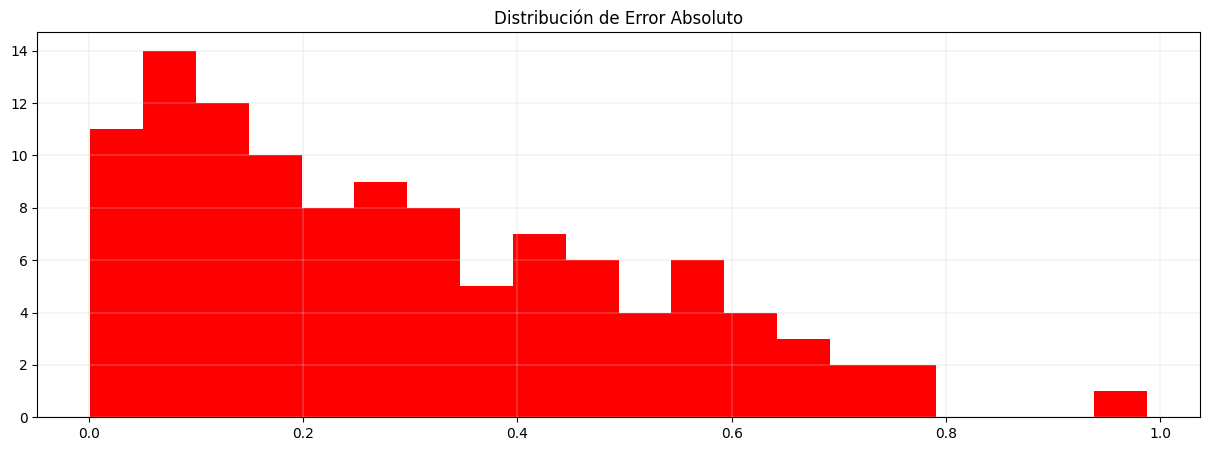


 Error Relativo: 
            Mínimo: 0.02% 
            Promedio: 4.93 ± 3.53
            Máximo: 14.50% 


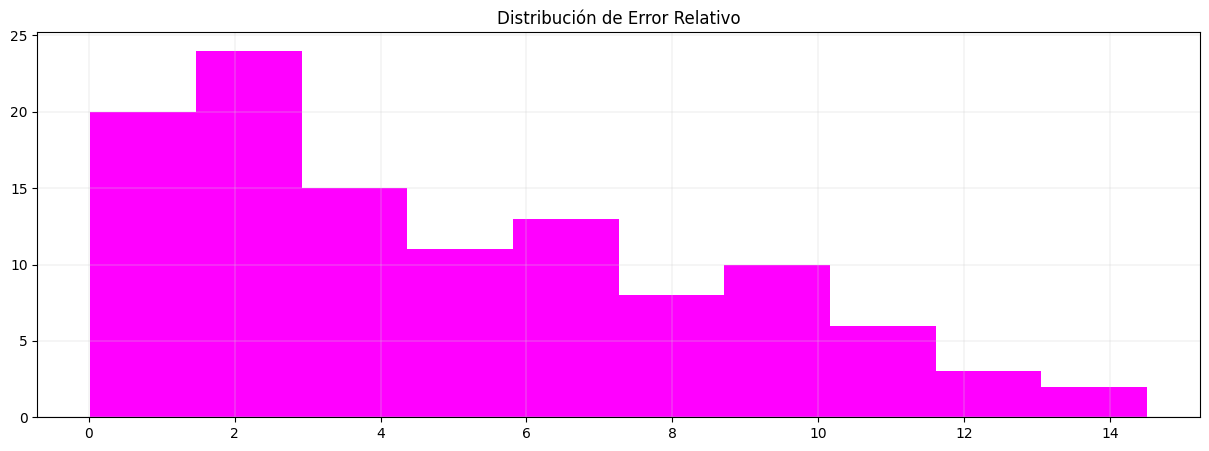

In [70]:
#@title Probar RNA con datos de entrenamiento
# función auxiliar para probar el modelo entrenado en detalle
from matplotlib import pyplot as plt


mostrarDetalle_Entrenamiento = True #@param{type:"boolean"}

# función auxiliar para el cálculo de error
def calcErrores(pred, real, mostrarDetalle=False):
  arAbs = []
  arRel = []

  if mostrarDetalle:
    print("\n")
    print("\t Real \t\t\t Estimado \t\t Error Absoluto \t Error Relativo")

  for pV, r in zip(pred, real):
    # toma el valor estimado/predecido
    p = pV[0]
    # controla que sean números
    if not(math.isnan(r) or math.isnan(p)):
      # hace los cálculos
      eAbs = abs(r - p)
      if r != 0:
        eRel = (eAbs / r)*100.0
      else:
        eRel = (eAbs / 0.00001)*100.0
      arAbs.append(eAbs)
      arRel.append(eRel)

      if mostrarDetalle:
        print("\t{:>8.2f} \t\t {:>8.2f} \t\t {:>8.2f} \t\t {:>8.2f}%".format(r, p, eAbs, eRel))

  return arAbs, arRel

def generarGrafico(ar, tit, b=10, c=None):
     # genera gráfico de los errores
    fig = plt.figure(figsize=(15,5))
 #   ax = fig.add_axes( [0, 0, 0.8, 0.8] )
 #   ax.boxplot( [arAbs, arRel] )
 #   ax.set_xticklabels( ["Error Absoluto", "Error Relativo"] )
#    plt.legend(["Error Absoluto", "Error Relativo"], loc='best')
    plt.hist( ar, bins=b, color=c )
    plt.grid(color='lightgrey', which='both', axis='both', linestyle='solid', linewidth=0.3)
    plt.title("Distribución de "+ tit)
    plt.show()


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Estimacion(x, y, detalle=False):

    # procesa las imágenes de prueba con el modelo
    estimVals = modelRNA.predict(x, verbose=0)

    # llama a la función
    arAbs, arRel = calcErrores(estimVals, y, detalle)

    # muestra métricas
    print("\n")
    print("\n Error Absoluto: ")
    print("            Mínimo: {:.5f} ".format(np.min(arAbs)) )
    print("            Promedio: {:.5f} ± {:.5f}".format(np.mean(arAbs), np.std(arAbs)) )
    print("            Máximo: {:.5f} ".format(np.max(arAbs)) )
    generarGrafico(arAbs, "Error Absoluto", 20, "red")

    print("\n Error Relativo: ")
    print("            Mínimo: {:.2f}% ".format(np.min(arRel)) )
    print("            Promedio: {:.2f} ± {:.2f}".format(np.mean(arRel), np.std(arRel)) )
    print("            Máximo: {:.2f}% ".format(np.max(arRel)) )
    generarGrafico(arRel, "Error Relativo", 10, "magenta")


# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
probarModelo_Estimacion(x_train, y_train, mostrarDetalle_Entrenamiento)


*** Resultados con datos de Prueba: 


	 Real 			 Estimado 		 Error Absoluto 	 Error Relativo
	    4.90 		     4.98 		     0.08 		     1.59%
	    5.10 		     5.05 		     0.05 		     0.88%
	    5.00 		     5.00 		     0.00 		     0.04%
	    6.10 		     6.27 		     0.17 		     2.86%
	    6.10 		     6.11 		     0.01 		     0.10%
	    5.00 		     5.05 		     0.05 		     1.10%
	    6.50 		     6.30 		     0.20 		     3.10%
	    5.10 		     5.08 		     0.02 		     0.42%
	    4.80 		     4.95 		     0.15 		     3.14%
	    5.10 		     5.03 		     0.07 		     1.31%
	    5.80 		     6.36 		     0.56 		     9.59%
	    5.10 		     5.08 		     0.02 		     0.40%
	    5.60 		     6.21 		     0.61 		    10.95%
	    4.90 		     5.77 		     0.87 		    17.66%
	    6.70 		     6.33 		     0.37 		     5.51%
	    5.80 		     6.50 		     0.70 		    12.08%
	    7.70 		     7.00 		     0.70 		     9.07%
	    5.10 		     5.15 		     0.05 		     1.07%
	    5.70 		     6.34 		     0.64 		    11.17%
	    4.80 		 

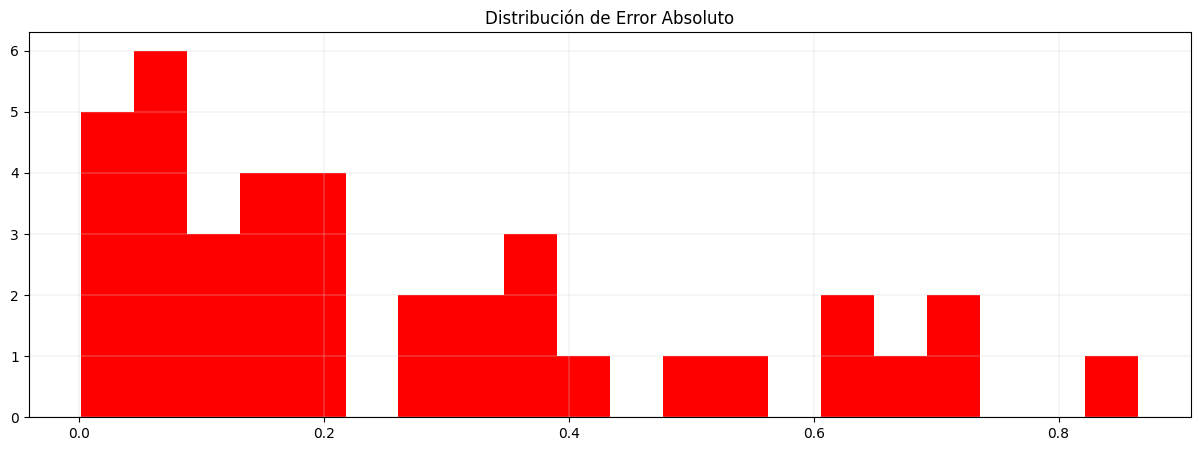


 Error Relativo: 
            Mínimo: 0.04% 
            Promedio: 4.64 ± 4.32
            Máximo: 17.66% 


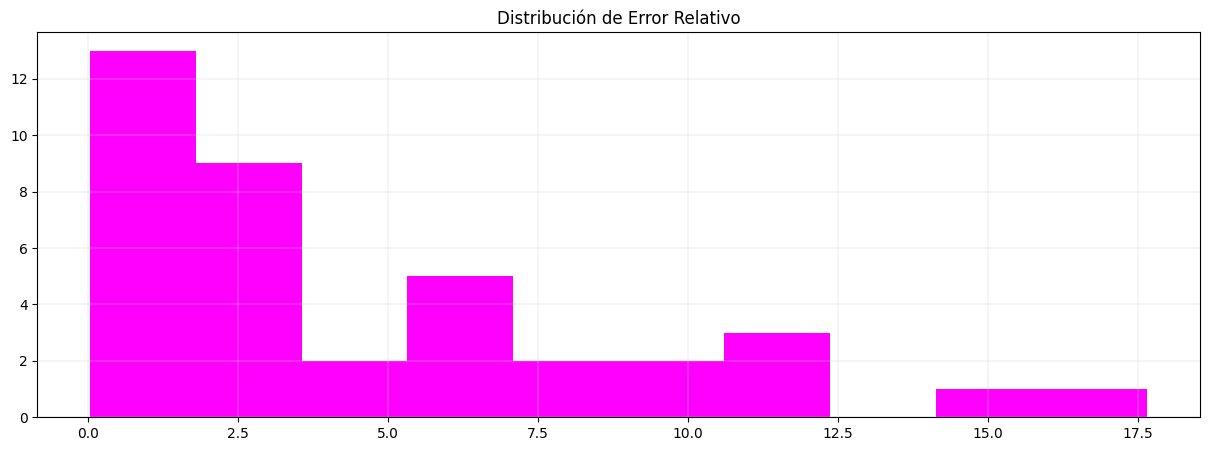

In [71]:
#@title Probar RNA con datos de prueba

mostrarDetalle_Prueba = True #@param{type:"boolean"}

print("*** Resultados con datos de Prueba: ")
probarModelo_Estimacion(x_test, y_test, mostrarDetalle_Prueba)